In [61]:
import pandas as pd
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error as RMSE
from src.help_func import add_weatherFeature, preprocess_data

pd.set_option('display.max_columns', None)

# Load Data & Preprocess

In [236]:
# load
path = './datathon-code/data'
ercot_hourly = pd.read_csv(path+'/ercot_hourly_load.csv')
ercot_hourly.fillna(method='backfill',inplace=True)
weather_history = pd.read_csv(path+'/weather_history.csv')
weather_forecast = pd.read_csv(path+'/weather_forecast.csv')


# preprocess
preprocess_data(ercot_hourly, weather_history.copy())

In [63]:
ercot_hourly.head()

,Coast,East,Far West,North,North Central,South,South Central,West
Hour_Ending,,,,,,,,
2005-01-01 07:00:00,7507.810731,850.313988,998.465500,741.963778,7312.259820,1883.979457,3728.400885,692.294503
2005-01-01 08:00:00,7257.549136,818.143264,987.532852,711.996586,7012.466197,1798.234153,3562.614723,675.176013
2005-01-01 09:00:00,6973.987199,783.396624,978.575662,687.881144,6712.807281,1712.758395,3373.868049,659.650453
2005-01-01 10:00:00,6794.489296,760.639635,959.486947,673.419383,6502.378446,1651.210254,3239.047417,648.512894
2005-01-01 11:00:00,6685.186677,743.371691,955.268590,664.792118,6440.559639,1627.872766,3176.859720,647.001780


In [7]:
weather_history.head()

,city,tempC,tempF,windspeedMiles,windspeedKmph,winddirDegree,winddir16Point,weatherCode,weatherDesc,precipMM,precipInches,humidity,visibility,visibilityMiles,pressure,pressureInches,cloudcover,HeatIndexC,HeatIndexF,DewPointC,DewPointF,WindChillC,WindChillF,WindGustMiles,WindGustKmph,FeelsLikeC,FeelsLikeF,uvIndex,region
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2008-07-01,Abilene,21,70,4,7,173,S,113,Clear,0.0,0.0,63,10,6,1018,31,6,24,76,14,57,21,70,9,15,21,70,1,West
2008-07-01,Austin,25,77,6,9,103,ESE,176,Patchy rain possible,0.6,0.0,61,9,5,1018,31,17,26,80,17,63,25,77,11,18,26,80,1,South Central
2008-07-01,Brownsville,26,79,5,8,150,SSE,113,Clear,0.0,0.0,86,10,6,1017,31,8,29,84,23,74,26,79,9,14,29,84,1,South
2008-07-01,Corpus Christi,26,78,8,12,146,SE,113,Clear,0.0,0.0,83,10,6,1017,30,7,28,83,23,73,26,78,13,21,28,83,1,South
2008-07-01,Dallas,25,76,6,9,149,SSE,113,Clear,0.0,0.0,46,10,6,1018,31,4,25,78,12,54,25,76,11,18,25,78,1,North Central


# Data Preparation

In [64]:
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

region = 'Coast'
region_data = ercot_hourly[[region]].copy()

# coast hourly load 
dr = pd.date_range(start='2008-01-01', end='2021-01-12')
cal = calendar()
holidays = cal.holidays(start=dr.min(), end=dr.max())

region_data['Holiday'] = region_data.index.isin(holidays)
region_data['Holiday'] = region_data['Holiday'].astype(int)


# adapt dataset for the model
region_data['hour'] = region_data.index.hour
region_data['month'] = region_data.index.month
region_data['year'] = region_data.index.year
region_data['dayofyear'] = region_data.index.dayofyear
region_data['week'] = region_data.index.weekofyear
# region_data['week_day'] = region_data.index.weekday
# region_data['days_in_month'] = region_data.index.days_in_month

# add weather features
region_data['DewPointC'] = add_weatherFeature(region,'DewPointC', weather_history)
region_data['uvindex'] = add_weatherFeature(region,'winddirDegree', weather_history)

region_data['last_hour'] = region_data[region].shift()
region_data['last_hour_diff'] = region_data[region].shift().diff()
# region_data['last_2_hours'] = region_data[region].shift(2)
region_data['last_2_hours_diff'] = region_data[region].shift(2).diff()
# region_data['last_3_hours_diff'] = region_data[region].shift(3).diff()
# region_data['last_4_hours_diff'] = region_data[region].shift(4).diff()
# region_data['last_5_hours_diff'] = region_data[region].shift(5).diff()
# region_data['last_6_hours_diff'] = region_data[region].shift(6).diff()
# region_data['last_7_hours_diff'] = region_data[region].shift(7).diff()
# region_data['last_8_hours_diff'] = region_data[region].shift(8).diff()
# region_data['last_9_hours_diff'] = region_data[region].shift(9).diff()
# region_data['last_10_hours_diff'] = region_data[region].shift(10).diff()
# region_data['last_11_hours_diff'] = region_data[region].shift(11).diff()
# region_data['last_12_hours_diff'] = region_data[region].shift(12).diff()
# region_data['last_13_hours_diff'] = region_data[region].shift(13).diff()
# region_data['last_14_hours_diff'] = region_data[region].shift(14).diff()
# region_data['last_15_hours_diff'] = region_data[region].shift(15).diff()
# region_data['last_12_hours_diff'] = region_data[region].shift().diff(16)
# region_data['last_6_hours_diff'] = region_data[region].shift().diff(6)
# region_data['last_day_diff'] = region_data[region].shift(2).diff()
region_data['roll_mean_3'] = region_data[region].shift(23).rolling(2).std()
region_data['last_day_diff'] = region_data[region].shift(23).diff()
# region_data['last_3_days_diff'] = region_data[region].shift().diff(24*3)
region_data['last_week_diff'] = region_data[region].shift(24*7).diff()
# region_data['last_4month_diff'] = region_data[region].shift().diff(24*30*4)
# region_data['roll_std12_t12'] = region_data[region].transform(lambda x: x.shift(24).rolling(3).std())

# make features
# region_data['last_hour'] = region_data[region].shift()
# region_data['last_hour_diff'] = region_data[region].shift().diff()
# region_data['roll_mean_3'] = region_data[region].shift().rolling(2).std()
# region_data['last_4_hours_diff'] = region_data[region].shift(4).diff()
# region_data['last_12_hours_diff'] = region_data[region].shift(12).diff()
# region_data['last_6_hours_diff'] = region_data[region].shift(6).diff()
# region_data['last_day_diff'] = region_data[region].shift(24).diff()
# region_data['last_2_days_diff'] = region_data[region].shift(24*2).diff()
# region_data['last_3_days_diff'] = region_data[region].shift(24*3).diff()
# region_data['last_week_diff'] = region_data[region].shift(24*7).diff()
# region_data['last_6month_diff'] = region_data[region].shift(24*30*6).diff()
# region_data['last_4month_diff'] = region_data[region].shift(24*30*4).diff()
# #lags
# region_data['roll_std12_t1'] = region_data[region].transform(lambda x: x.shift().rolling(6).std())
# region_data['roll_std12_t170'] = region_data[region].transform(lambda x: x.shift().rolling(170).std())
# region_data['lag_170'] = region_data[region].shift().diff(170)

# region_data['lag_74'] = region_data[region].shift().diff(74)
# region_data['lag_98'] = region_data[region].shift().diff(98)
# region_data['lag_122'] = region_data[region].shift().diff(122)
# region_data['lag_146'] = region_data[region].shift().diff(146)
# # region_data['last_day'] = region_data[region].shift(24)
# # region_data['last_2_days'] = region_data[region].shift(24*2)
# # region_data['last_3_days'] = region_data[region].shift(24*3)
# # region_data['last_week'] = region_data[region].shift(24*7)
# # region_data['roll_std12_t12'] = region_data[region].transform(lambda x: x.shift(12).rolling(12).std())
# # region_data['roll_std12_t24'] = region_data[region].transform(lambda x: x.shift(24).rolling(12).std())
# # region_data['roll_std24_t1'] = region_data[region].transform(lambda x: x.shift().rolling(24).std())
# # region_data['roll_std24_t12'] = region_data[region].transform(lambda x: x.shift(12).rolling(24).std())
# # region_data['roll_std24_t24'] = region_data[region].transform(lambda x: x.shift(24).rolling(24).std())
# # region_data['roll_std12_t48'] = region_data[region].transform(lambda x: x.shift(48).rolling(12).std())
# # region_data['roll_std24_t48'] = region_data[region].transform(lambda x: x.shift(48).rolling(24).std())

region_data.dropna(inplace=True)

<ipython-input-64-935c01857699>:21: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  region_data['week'] = region_data.index.weekofyear


# Modeling

### TESTING

In [65]:
train = region_data.loc['2008':'2020'].reset_index(drop=True)
valid = region_data.loc['2020'].reset_index(drop=True)
test = region_data.loc['2021':].reset_index(drop=True)

In [66]:
def train_lgbm(train,valid,n_est=2200, lr=0.009):
    
    params = {
    'boosting_type':'gbdt',
#     'objective':'rmse',
    'num_leaves':18,
#     'max_depth':1,
    'learning_rate':0.08,
    'n_estimators':1700,
    'force_col_wise':True,
#     'min_child_samples':15,
#     'min_child_weight':0.01,
#     bagging_fraction:0.8,
#     feature_fraction:0.9,
#     colsample_bytree:0.7,
#     reg_alpha:0.0,
#     reg_lambda:0.0,
    'random_state':42,
    'silent':True
    }
    
    drop = [region,'month','week']
    X_test, y_test = test.drop(drop, axis=1), test[region]
    
    predictions=[]
    mean_rmse = 0
    for week in range(5,25):
        # rolling - windows size = week
        train_frame = train[((train['year'] == 2020) & (train['week'] < week)) | ((train['year'] < 2020))]
        valid_frame = valid[valid['week'] == week]
        
        # train , valid
        X_train, y_train = train_frame.drop(drop, axis=1), train_frame[region]
        X_valid, y_valid = valid_frame.drop(drop, axis=1), valid_frame[region]
#         eval_set_R = [(X_train, y_train), (X_test, y_test)]
        
        # train
        model = LGBMRegressor(**params, verbose=0)
        model.fit(X_train, np.log1p(y_train),
#                   eval_metric='rmse',
#                   eval_set = eval_set_R,
#                   early_stopping_rounds=15,
                  verbose=20,)

        # validation
        pred = np.expm1(model.predict(X_valid))
        predictions.append(pred)
        
        # RMSE
        error = round(RMSE(y_valid, pred, squared=False))
        print(f'Week {week}: RMSE: {error}')
        
        # Mean RMSE
        mean_rmse += error
        
    print(f'Mean Error: {round(mean_rmse/20)}')
    return(predictions, model)

In [67]:
pred, model = train_lgbm(train, valid)

Week 5: RMSE: 73
Week 6: RMSE: 81
Week 7: RMSE: 77
Week 8: RMSE: 64
Week 9: RMSE: 71
Week 10: RMSE: 81
Week 11: RMSE: 78
Week 12: RMSE: 92
Week 13: RMSE: 110
Week 14: RMSE: 79
Week 15: RMSE: 114
Week 16: RMSE: 92
Week 17: RMSE: 122
Week 18: RMSE: 125
Week 19: RMSE: 95
Week 20: RMSE: 124
Week 21: RMSE: 95
Week 22: RMSE: 171
Week 23: RMSE: 117
Week 24: RMSE: 124
Mean Error: 99


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

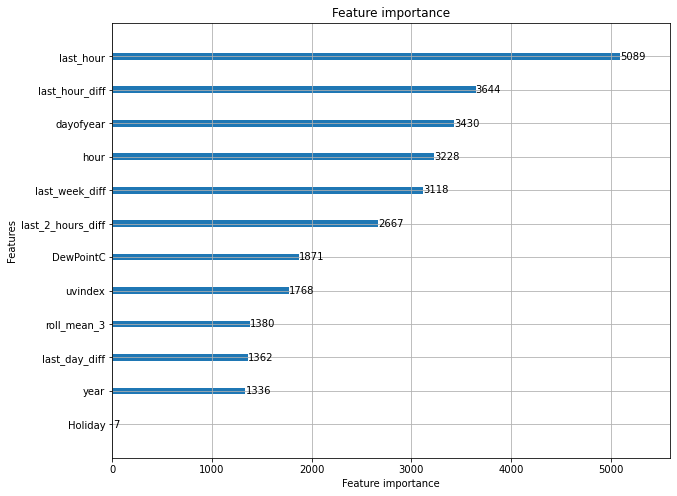

In [68]:
import lightgbm as lgb
lgb.plot_importance(model, figsize=(10,8))

In [39]:
pred, model = train_lgbm(train, valid)

Week 5: RMSE: 69
Week 6: RMSE: 75
Week 7: RMSE: 78
Week 8: RMSE: 66
Week 9: RMSE: 83
Week 10: RMSE: 82
Week 11: RMSE: 80
Week 12: RMSE: 88
Week 13: RMSE: 114
Week 14: RMSE: 82
Week 15: RMSE: 112
Week 16: RMSE: 86
Week 17: RMSE: 115
Week 18: RMSE: 118
Week 19: RMSE: 98
Week 20: RMSE: 124
Week 21: RMSE: 94
Week 22: RMSE: 172
Week 23: RMSE: 112
Week 24: RMSE: 122
Mean Error: 98


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

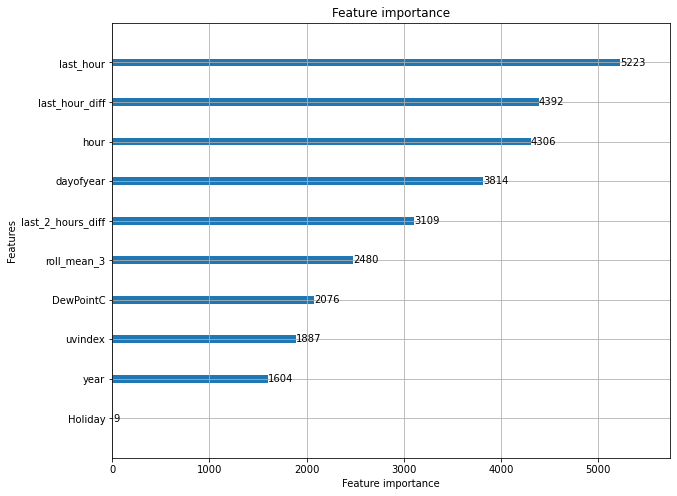

In [40]:
lgb.plot_importance(model, figsize=(10,8))

In [41]:
model.fit(train.drop([region,'week','month'],axis=1), np.log1p(train[region]))

LGBMRegressor(force_col_wise=True, learning_rate=0.08, n_estimators=1700,
              num_leaves=18, random_state=42, verbose=0)

75.3863120980259


<AxesSubplot:>

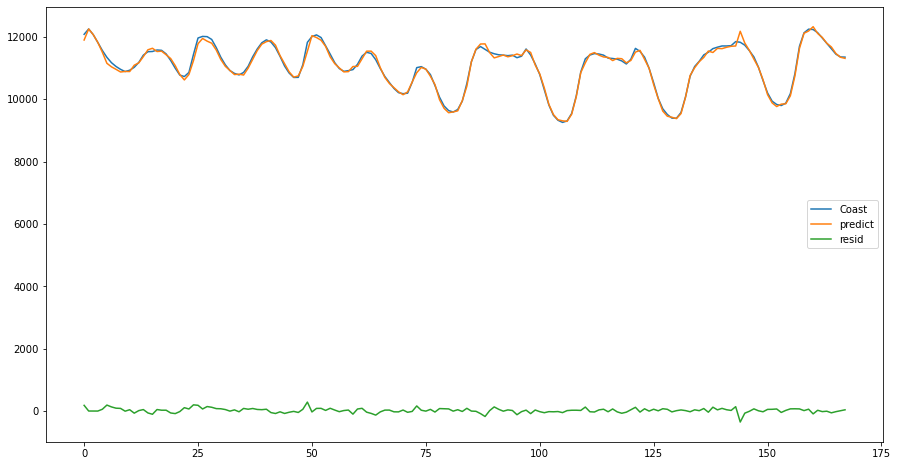

In [42]:
x_test, y_test= test.drop([region,'month','week'], axis=1), test[[region]].copy()
pred = np.expm1(model.predict(x_test.iloc[0:168]))
print(RMSE(y_test.iloc[0:168], pred,squared=False))

forecasted = test[[region]].copy()
forecasted['predict'] = np.expm1(model.predict(x_test))
forecasted['resid'] = forecasted[region] - forecasted['predict']
forecasted.iloc[:24*7].plot(figsize=(15,8))

### LightGBM Week Forecast

In [251]:
from lightgbm import LGBMRegressor
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar


class gbm_forecast():
    '''
    Forecast the next 168 values, for a week forecast.
    '''
    
    def __init__(self, data, region, weather_history, weather_forecast):
        self.region = region
        self.weather = weather_history.append(weather_forecast).copy()
        self.region_data = data[[region,'Hour_Ending']].copy()
        self.weather_forecast = weather_forecast.copy()

        # preprocess weather and region data
        self.preprocess_data()
        self.build_features()
        
        # train and forecast
        self.train()
        self.forecast()
        
    def add_weatherFeature(self, feature):
        feature_index = self.weather[self.weather['region'] == self.region].index
        return(self.weather[self.weather['region'] == self.region].groupby(by=feature_index).mean().resample('1H').bfill()[feature])
    
    def build_features(self):
        
        self.region_data['hour'] = self.region_data.index.hour
        self.region_data['year'] = self.region_data.index.year
        self.region_data['dayofyear'] = self.region_data.index.dayofyear
        self.region_data['DewPointC'] = self.add_weatherFeature('DewPointC')
        self.region_data['uvIndex'] = self.add_weatherFeature('uvIndex')
        self.region_data['last_hour'] = self.region_data[self.region].shift()
        self.region_data['last_hour_diff'] = self.region_data[self.region].shift().diff()
        self.region_data['last_2_hours_diff'] = self.region_data[self.region].shift(2).diff()
#         self.region_data['last_week_diff'] = self.region_data[self.region].shift(24*7).diff()
        self.region_data['roll_mean_3'] = self.region_data[self.region].shift(24).rolling(2).std()

#         self.region_data['hour'] = self.region_data.index.hour
#         self.region_data['year'] = self.region_data.index.year
#         self.region_data['dayofyear'] = self.region_data.index.dayofyear
#         self.region_data['tempC'] = self.add_weatherFeature('tempC')
#         self.region_data['last_hour_std'] = self.region_data[self.region].rolling(2).std()
#         self.region_data['last_hour_diff'] = self.region_data[self.region].shift().diff()
#         self.region_data['last_2_hours_diff'] = self.region_data[self.region].shift(2).diff()
#         self.region_data['last_2_hours_std'] = self.region_data[self.region].rolling(3).std()
#         self.region_data['roll_mean_3'] = self.region_data[self.region].shift(24).rolling(2).std()
        
        self.region_data.dropna(inplace=True)
        
    def preprocess_data(self, data=None):
        # PREPROCESS WEATHER
        
        # transform time into hours:minutes
        time = {'time':{0:'00:00',300:'03:00',600:'06:00',900:'09:00',1200:'12:00',
                        1500:'15:00',1800:'18:00',2100:'21:00'}}
        self.weather.replace(time, inplace=True)

        # join date + time
        self.weather['date'] = self.weather.date + " " + self.weather.time.map(str)
        self.weather.drop(columns={'time'}, inplace=True)

        # make timeindex
        self.weather.date = pd.DatetimeIndex(self.weather.date)
        self.weather.set_index('date', inplace=True)

        # transform city to region
        city_region = {'Wichita Falls':'North',
                       'Tyler':'East',
                       'Corpus Christi':'South',
                       'Brownsville':'South',
                       'Dallas':'North Central',
                       'Austin':'South Central',
                       'Midland':'Far West',
                       'San Antonio':'South Central',
                       'Houston':'Coast',
                       'Abilene':'West'}

        self.weather['region'] = self.weather.city.replace(city_region)

        
        # PREPROCESS POWER DEMAND ERCOT HOURLY      
        
        # Convert CST & CDT to UTC
        self.region_data['Hour_Ending']= pd.to_datetime(self.region_data['Hour_Ending'],utc= True)
        # Datetimeindex
        self.region_data.set_index("Hour_Ending", inplace=True)
        self.region_data = self.region_data.tz_convert(tz='US/Central').tz_localize(tz=None)       
        
        # add hollidays
        dr = pd.date_range(start='2008-01-01', end='2021-06-20')
        cal = calendar()
        self.holidays = cal.holidays(start=dr.min(), end=dr.max())

        self.region_data['Holiday'] = self.region_data.index.isin(self.holidays)
        self.region_data['Holiday'] = self.region_data['Holiday'].astype(int)
        
    def train(self):
        
        train = self.region_data.reset_index(drop=True)
        
        params = {
            'boosting_type':'gbdt',
            'num_leaves':18,
        #     'max_depth':1,
            'learning_rate':0.08,
            'n_estimators':1500,
            'force_col_wise':True,
            'random_state':42,
            'silent':True
            }
        
        self.model = LGBMRegressor(**params)
        self.model.fit(train.drop([self.region],axis=1), np.log1p(train[self.region]))
        self.train_data = train
    
    def forecast(self):
        
        forecasted = []
        # week forecast
        for idx in range(24*7):
            region_data = self.region_data.iloc[[-1]].copy()

            point_value = region_data.drop([self.region],axis=1)

            forecasted.append(np.expm1(self.model.predict(point_value)[0]))

            if region_data.index.hour == 0:
                region_data['hour'] = 1
                region_data['dayofyear'] = region_data.index.dayofyear +1

            else:
                region_data['hour'] = region_data.index.hour + 1

            # make next dataframe
            region_data['last_hour'] = self.region_data[self.region].iloc[-1]
            region_data['last_hour_diff'] = self.region_data[self.region].diff().iloc[-1]
            region_data['last_2_hours_diff'] = self.region_data[self.region].shift(1).diff().iloc[-1]
#             region_data['last_week_diff'] = self.region_data[self.region].shift(24*7).diff().iloc[-1]
            region_data['roll_mean_3'] = self.region_data[self.region].shift(23).rolling(2).std()[-1]
            region_data.index += pd.TimedeltaIndex([1], unit='h')
            region_data['DewPointC'] = self.add_weatherFeature('DewPointC')
            region_data['uvIndex'] = self.add_weatherFeature('uvIndex')
            region_data['Holiday'] = region_data.index.isin(self.holidays)
            region_data['Holiday'] = region_data['Holiday'].astype(int) 
            region_data[self.region] = np.expm1(self.model.predict(region_data.drop([self.region],axis=1)))

#             region_data['last_hour_std'] = self.region_data[self.region].rolling(2).std().iloc[-1]
#             region_data['last_hour_diff'] = self.region_data[self.region].diff().iloc[-1]
#             region_data['last_2_hours_diff'] = self.region_data[self.region].shift(1).diff().iloc[-1]
#             region_data['last_2_hours_std'] = self.region_data[self.region].rolling(2).std().iloc[-1]
#             region_data['roll_mean_3'] = self.region_data[self.region].shift(24).rolling(2).std()[-1]
#             region_data.index += pd.TimedeltaIndex([1], unit='h')
#             region_data['tempC'] = self.add_weatherFeature('tempC')
#             region_data['Holiday'] = region_data.index.isin(self.holidays)
#             region_data['Holiday'] = region_data['Holiday'].astype(int) 
#             region_data[self.region] = np.expm1(self.model.predict(region_data.drop([self.region],axis=1)))
            
            # append new data to train 
            self.region_data = self.region_data.append(region_data)

In [252]:
# load data
ercot_hourly = pd.read_csv(path+'/ercot_hourly_load.csv')
ercot_hourly.fillna(method='backfill',inplace=True)

# forecast
data = ercot_hourly[(ercot_hourly['Hour_Ending'] < '2021') & (ercot_hourly['Hour_Ending'] > '2014')].copy()
coast = gbm_forecast(data,'Coast', weather_history, weather_forecast)

<AxesSubplot:xlabel='Hour_Ending'>

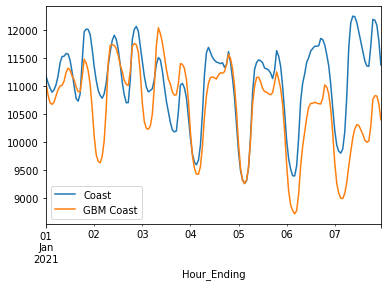

In [253]:
preprocess_data(ercot_hourly, weather_history.copy())
gbm_forecast = ercot_hourly.loc[:'2021'].tz_localize(tz='utc').tz_convert(tz='US/Central')[['Coast']].copy()
gbm_forecast = gbm_forecast.tz_localize(tz=None)
gbm_forecast['GBM Coast'] = coast.region_data.tail(24*7)['Coast']
gbm_forecast.dropna(inplace=True)
gbm_forecast.plot()

In [255]:
gbm_rmse = RMSE(gbm_forecast['Coast'].values,gbm_forecast['GBM Coast'].values, squared=False)
print(gbm_rmse)

752.29424690362


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

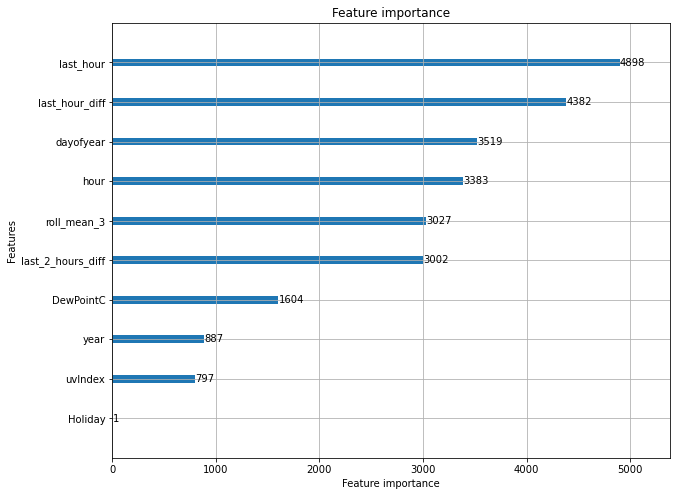

In [102]:
import lightgbm as lgb
lgb.plot_importance(coast.model, figsize=(10,8))

## LSTM Week Forecast

In [257]:
import pandas as pd
import tensorflow as tf
import functools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

class forecast_LSTM():
    def __init__(self, model,data,region):
        self.data = data.copy()
        self.model = model
        self.region = region
        
        self.preprocess()
        self.forecast()
        
    def preprocess(self):
        
        # Convert CST & CDT to UTC
        self.data['Hour_Ending']= pd.to_datetime(self.data['Hour_Ending'],utc= True)
        # Datetimeindex
        self.data.set_index("Hour_Ending", inplace=True)
        self.data = self.data.tz_convert(tz='US/Central')
        self.data = self.data.tz_localize(tz=None)
        
    def forecast(self):
        window = 24*7
        train_test = self.data.tail(window)[self.region].values
        scaler = StandardScaler()
        scaler.fit(self.data[self.region].values.reshape(-1,1))
        train_t_scaled = scaler.fit_transform(train_test.reshape(-1,1))
        forcast = []
        for idx in range(0,24*7,24):
            pred = self.model_forecast(self.model, train_t_scaled[idx:window + idx][...,np.newaxis], 1).reshape(-1,1)[:24]
            forcast = np.append(forcast,pred)
            train_t_scaled = np.append(train_t_scaled,pred)
            
        self.forecast = scaler.inverse_transform(forcast)
        
    # transforma os dados para previsões
    def model_forecast(self,model, series, window_size):
        ds = tf.data.Dataset.from_tensor_slices(series)
        ds = ds.window(window_size, shift=1, drop_remainder=True)
        ds = ds.flat_map(lambda w: w.batch(window_size))
        ds = ds.batch(32).prefetch(1)
        forecast = model.predict(ds)
        return(forecast)

In [258]:
# load LSTM Model
checkpoint_path = 'lstm_models_checkpoints'
model = tf.keras.models.load_model(checkpoint_path+'/best_model.h5')

In [259]:
ercot_hourly = pd.read_csv(path+'/ercot_hourly_load.csv')
ercot_hourly.fillna(method='backfill',inplace=True)

data = ercot_hourly[ercot_hourly['Hour_Ending'] < '2021'].copy()
coast_lstm = forecast_LSTM(model,data,'Coast')

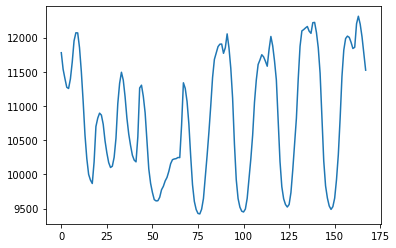

In [260]:
plt.plot(coast_lstm.forecast)

<AxesSubplot:xlabel='Hour_Ending'>

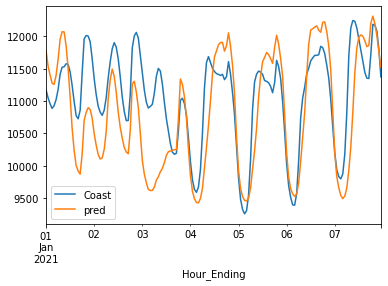

In [261]:
# preprocess ercot hourly
preprocess_data(ercot_hourly, weather_history.copy())

# lstm_forecast x test
lstm_forecast = ercot_hourly.tz_localize(tz='utc').tz_convert(tz='US/Central')[['Coast']].copy()
lstm_forecast = lstm_forecast.tz_localize(tz=None)
lstm_forecast = lstm_forecast.loc['2021'].head(24*7)
lstm_forecast['pred'] = coast_lstm.forecast
lstm_forecast.dropna(inplace=True)
lstm_forecast.plot()

In [262]:
lstm_rmse = RMSE(forecast['Coast'].values,forecast['pred'].values, squared=False)
print(f'LSTM RMSE: {lstm_rmse}')

LSTM RMSE: 678.8734175055857


## LSTM with LightGBM

<AxesSubplot:xlabel='Hour_Ending'>

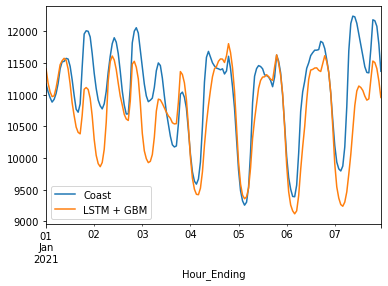

In [267]:
gbm_forecast['LSTM Coast'] = lstm_forecast['pred'].copy()
gbm_forecast['LSTM + GBM'] = (gbm_forecast['LSTM Coast'] + gbm_forecast['GBM Coast'])/2
gbm_forecast[['Coast','LSTM + GBM']].plot()

In [268]:
lstm_gbm_rmse = RMSE(gbm_forecast['Coast'].values,gbm_forecast['LSTM + GBM'].values, squared=False)
print(f'LSTM RMSE: {lstm_gbm_rmse}')

LSTM RMSE: 571.9156075172118


### Observations:
The best solution was the two models LSTM and LightGBM working together, as expected.

### This is the final of the project.
For the competition, we trained for each region the two models and joined their forecast.

**PS: For some Regions we had to build some other features, also use other weather's features. As we mentioned in the Data Understanding notebook.**